# Importing Dependencies
We will be using Tensorflow for the network, and Scikit-learn for the GLCM computation.

In [1]:
import os
import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

2021-10-01 05:59:49.959491: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
train_dir = 'C:/Users/Ashvini Alashetty/input/chest-xray-covid19-pneumonia/Data/train/*'
test_dir = 'C:/Users/Ashvini Alashetty/input/chest-xray-covid19-pneumonia/Data/test/*'
train2_covid_dir = 'C:/Users/Ashvini Alashetty/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID'

In [3]:
SIZE = 140
BATCH_SIZE = 64
TARGET_SIZE = (SIZE,SIZE)
EPOCH_NUM = 140

In [4]:
categories_dict = {
  0: "PNEUMONIA",
  1: "NORMAL",
  2: "COVID19"
}

# Data Loading

In [5]:
train_images = []
train_labels = [] 
label = 0

#Importing the first training dataset

for directory_path in glob.glob(train_dir):
    assert categories_dict[label] == os.path.normpath(directory_path).split(os.path.sep)[-1]
    print(categories_dict[label])
    counter = 1
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        if(counter%200==0): print(counter,"images loaded")
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        train_images.append(img)
        train_labels.append(label)
        counter+=1
        if(counter%1500==0): break
    
    print(counter,"images loaded")
    label +=1
    
#Importing the additional training dataset

print("additional",categories_dict[2],"data")    
addit_counter = 1
for img_path in glob.glob(os.path.join(train2_covid_dir, "*.png")):
    if(addit_counter%200==0): print(addit_counter,"images loaded")
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, TARGET_SIZE)
    train_images.append(img)
    train_labels.append(2)
    addit_counter+=1
    if(addit_counter%1000==0): break
print(addit_counter,"images loaded")

x_train = np.array(train_images)
y_train = to_categorical(train_labels, 3)

PNEUMONIA
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded
1200 images loaded
1400 images loaded
1500 images loaded
NORMAL
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded
1200 images loaded
1267 images loaded
COVID19
200 images loaded
400 images loaded
461 images loaded
additional COVID19 data
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded


In [6]:
test_images = []
test_labels = []
label = 0

#importing the testing dataset

for directory_path in glob.glob(test_dir):
    assert categories_dict[label] == os.path.normpath(directory_path).split(os.path.sep)[-1]
    print(categories_dict[label])
    counter = 1
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        if(counter%100==0): print(counter, "images loaded")
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        test_images.append(img)
        test_labels.append(label)
        counter+=1
    
    print(counter,"images loaded")
    label +=1

test_images = np.array(test_images)
test_labels = to_categorical(test_labels, 3)

PNEUMONIA
100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
856 images loaded
NORMAL
100 images loaded
200 images loaded
300 images loaded
318 images loaded
COVID19
100 images loaded
117 images loaded


**Splitting data into train and validation dataset**

In [7]:
train_test_split(train_images, train_labels)
train_images, val_images, train_labels, val_labels = train_test_split(x_train, y_train, test_size=0.15, random_state=69)

In [8]:
print("train:",train_images.shape[0],", test:",test_images.shape[0],", val:",val_images.shape[0])

train: 3590 , test: 1288 , val: 634


# "Traditional" Feature Extraction with GLCM

In [9]:
def feature_extractor(images):
    image_dataset = pd.DataFrame()
    for image in images:   
        df = pd.DataFrame()
        
        #greycomatrix(image, distances, angles, levels=256, symmetric=False, normed=False)
        #distances - List of pixel pair distance offsets.
        #angles - List of pixel pair angles in radians.
        
        #5 configuration for the grey-level co-occurrence matrix calculation
        dists = [[1],[3],[5],[3],[3]]
        angles = [[0],[0],[0],[np.pi/4],[np.pi/2]]
        
        for n ,(dist, angle) in enumerate(zip(dists, angles)):
        
            GLCM = greycomatrix(image, dist, angle)       
            GLCM_Energy = greycoprops(GLCM, 'energy')[0]
            df['Energy'+str(n)] = GLCM_Energy
            GLCM_corr = greycoprops(GLCM, 'correlation')[0]
            df['Corr'+str(n)] = GLCM_corr       
            GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
            df['Diss_sim'+str(n)] = GLCM_diss       
            GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
            df['Homogen'+str(n)] = GLCM_hom       
            GLCM_contr = greycoprops(GLCM, 'contrast')[0]
            df['Contrast'+str(n)] = GLCM_contr

        image_dataset = image_dataset.append(df)
        
    return image_dataset

In [10]:
train_extr_features = feature_extractor(train_images)

In [11]:
test_extr_features = feature_extractor(test_images)

In [12]:
val_extr_features = feature_extractor(val_images)

In [13]:
type(train_images)
# convert from integers to floats
train_images_norm = train_images.astype('float32')
test_images_norm = test_images.astype('float32')
val_images_norm = val_images.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

In [14]:
pd.set_option("display.max_columns", None)
train_extr_features

,Energy0,Corr0,Diss_sim0,Homogen0,Contrast0,Energy1,Corr1,Diss_sim1,Homogen1,Contrast1,Energy2,Corr2,Diss_sim2,Homogen2,Contrast2,Energy3,Corr3,Diss_sim3,Homogen3,Contrast3,Energy4,Corr4,Diss_sim4,Homogen4,Contrast4
0,0.051959,0.960339,8.046711,0.180405,166.620915,0.032321,0.867067,16.106934,0.102895,537.779927,0.019734,0.760146,22.212910,0.068772,935.377566,0.039897,0.893736,14.640359,0.109834,434.033239,0.058261,0.918441,12.481439,0.156674,344.977477
0,0.041816,0.964296,8.770966,0.170647,243.837050,0.023285,0.883300,18.464859,0.090727,754.464442,0.014953,0.781649,25.925344,0.060795,1339.489683,0.030758,0.917577,15.610271,0.104754,544.047364,0.050792,0.939250,13.211053,0.146042,421.810010
0,0.136676,0.980152,7.506064,0.270158,176.751182,0.112109,0.922724,16.543900,0.183539,667.006569,0.089465,0.841393,24.221429,0.138988,1322.881534,0.125484,0.952733,12.789120,0.210512,416.018694,0.144165,0.977553,8.414755,0.265631,204.044786
0,0.022921,0.966988,4.984430,0.233775,85.268088,0.017010,0.906336,10.212461,0.114237,237.107143,0.015032,0.839683,14.195608,0.074929,398.318889,0.017813,0.924610,8.851869,0.133667,192.553508,0.019621,0.952262,6.677581,0.192688,124.506569
0,0.046807,0.959015,9.921583,0.150144,256.150874,0.027441,0.859055,20.186705,0.085074,835.675965,0.013250,0.723485,28.675661,0.052614,1555.242434,0.036712,0.893276,17.843940,0.096829,644.273892,0.056382,0.917971,15.299062,0.140528,520.659541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.028802,0.976066,4.902569,0.281079,104.181192,0.020598,0.898507,11.556569,0.142410,429.908290,0.017891,0.802562,17.026561,0.099124,815.143810,0.021876,0.932322,9.361794,0.158139,289.437408,0.025303,0.969692,6.379562,0.224894,133.235975
0,0.018658,0.971788,9.059198,0.158631,201.731860,0.013848,0.891940,18.492596,0.081832,728.038895,0.012343,0.789360,26.007407,0.054522,1350.414815,0.014781,0.928075,15.340002,0.094798,498.916877,0.018281,0.962726,10.911940,0.146999,275.243014
0,0.134007,0.960929,10.777852,0.218841,335.900565,0.109444,0.889472,20.651825,0.153083,928.876955,0.086208,0.812980,28.105397,0.118835,1533.818413,0.122754,0.922413,17.025835,0.172592,655.359798,0.143035,0.942345,13.944265,0.216826,496.664703
0,0.044756,0.967444,8.565570,0.167248,210.465365,0.024382,0.884524,18.086184,0.091016,709.749062,0.015681,0.775340,25.648307,0.065215,1320.787249,0.032229,0.910622,16.033711,0.101735,559.598719,0.053356,0.930006,13.702138,0.144889,459.848749


# Building the Network

**Convolutional Neural Network to extract the high-level features**

In [15]:
def build_cnn():
    model = keras.Sequential([
        keras.Input(shape=(140,140,1), name='Original_Images'),
        keras.layers.Conv2D(input_shape=(140,140,1), filters=32, kernel_size=11, 
                            strides=1, activation='relu', name='Conv1'),
        keras.layers.Conv2D(input_shape=(130,130,32), filters=32, kernel_size=11, 
                            strides=1, activation='relu', name='Conv2'),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2),
        keras.layers.Conv2D(input_shape=(58,58,32), filters=64, kernel_size=9, 
                            strides=1, activation='relu', name='Conv3'),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2),
        keras.layers.Conv2D(input_shape=(23,23,64), filters=128, kernel_size=8, 
                            strides=1, activation='relu', name='Conv4'),
        keras.layers.Conv2D(input_shape=(16,16,128), filters=256, kernel_size=9, 
                            strides=1, activation='relu', name='Conv5'),
        keras.layers.Conv2D(input_shape=(8,8,256), filters=256, kernel_size=8, 
                            strides=1, activation='relu', name='Conv6'),    

        keras.layers.Flatten(),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense')
    ])
    print(model.summary())
    return model

**Multilayer Perceptron to learn the numerical feature data extracted from the GLCM**

In [16]:
def build_mlp():
    model = keras.Sequential([
        keras.Input(shape=25, name='Extracted_Traditional_Features'),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense1'),
        keras.layers.Dense(4, activation=tf.keras.activations.relu, name='Dense2')
    ])
    print(model.summary())
    return model

**Intertwining the 2 feature extractor**

In [17]:
mlp = build_mlp()
cnn = build_cnn()

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(8, activation="relu")(combinedInput)
x = Dense(3, activation="softmax")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)


2021-10-01 06:05:31.065029: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-01 06:05:31.073115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-01 06:05:31.120660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 06:05:31.121826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-01 06:05:31.121889: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-01 06:05:31.181444: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 8)                 208       
_________________________________________________________________
Dense2 (Dense)               (None, 4)                 36        
Total params: 244
Trainable params: 244
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 130, 130, 32)      3904      
_________________________________________________________________
Conv2 (Conv2D)               (None, 120, 120, 32)      123936    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 58, 32)        0         
_______________________________

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.005)

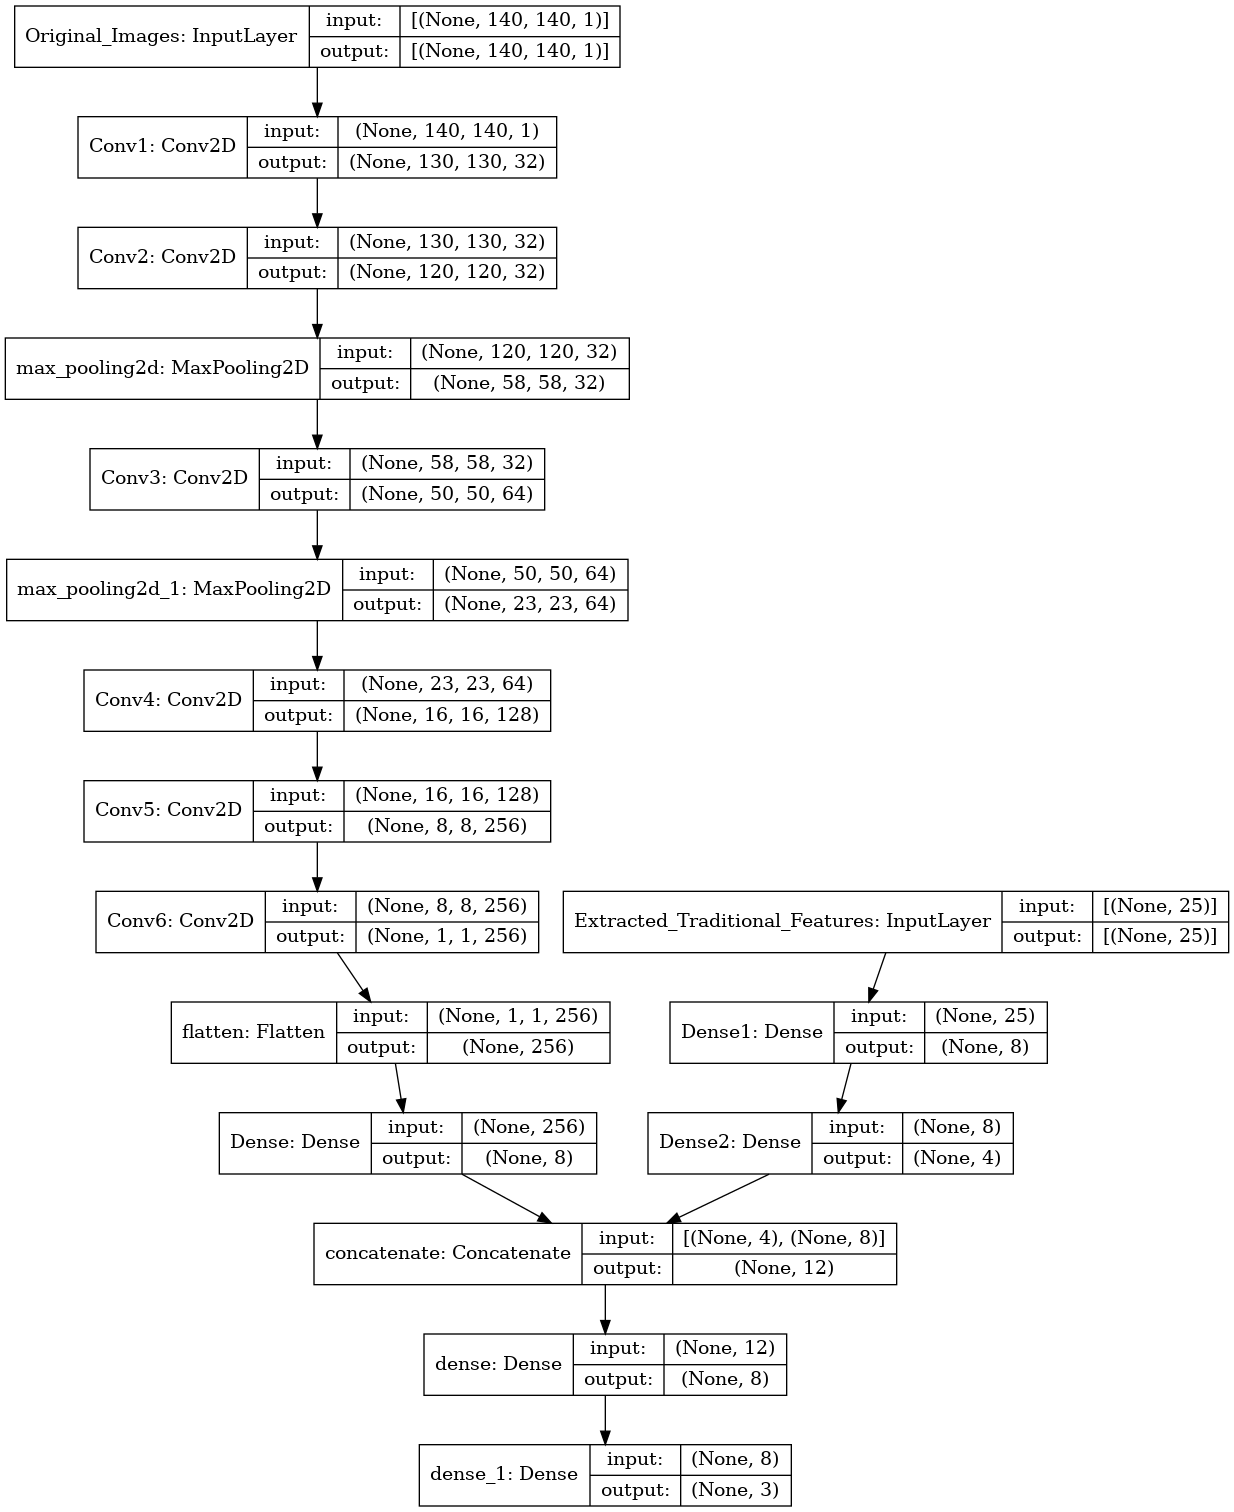

In [19]:
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Reduce Learning Rate on Plateau**, to reduce the learning rate gradually if there is no significant improvement on the performance of the network. 

In [20]:

from tensorflow.keras.callbacks import ReduceLROnPlateau

cb = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-8,
        verbose=1,
    )
]



# Learning

In [21]:
dataset_inputs = tf.data.Dataset.from_tensor_slices((train_extr_features, tf.expand_dims(train_images_norm, axis=-1)))
dataset_label = tf.data.Dataset.from_tensor_slices(train_labels)

dataset = tf.data.Dataset.zip((dataset_inputs, dataset_label)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TRAIN= train_images_norm.shape[0]//BATCH_SIZE
# fit model
history = model.fit(dataset, 
                    validation_data=([val_extr_features, tf.expand_dims(val_images_norm, axis=-1)], val_labels),
                    epochs = EPOCH_NUM, steps_per_epoch=STEP_SIZE_TRAIN, callbacks=cb)



Epoch 1/140


2021-10-01 06:05:37.436276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-01 06:05:37.446627: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2021-10-01 06:05:37.629063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-01 06:05:38.510998: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-01 06:05:38.543649: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


56/56 [==============================] - 14s 89ms/step - loss: 65.1248 - categorical_accuracy: 0.2635 - val_loss: 1.5501 - val_categorical_accuracy: 0.4117
Epoch 2/140
56/56 [==============================] - 4s 67ms/step - loss: 1.4342 - categorical_accuracy: 0.4101 - val_loss: 1.1631 - val_categorical_accuracy: 0.4890
Epoch 3/140
56/56 [==============================] - 4s 67ms/step - loss: 1.1095 - categorical_accuracy: 0.5052 - val_loss: 1.0192 - val_categorical_accuracy: 0.5489
Epoch 4/140
56/56 [==============================] - 4s 65ms/step - loss: 0.9879 - categorical_accuracy: 0.5568 - val_loss: 0.9693 - val_categorical_accuracy: 0.6073
Epoch 5/140
56/56 [==============================] - 4s 66ms/step - loss: 0.9476 - categorical_accuracy: 0.6036 - val_loss: 0.9353 - val_categorical_accuracy: 0.6278
Epoch 6/140
56/56 [==============================] - 4s 66ms/step - loss: 0.9229 - categorical_accuracy: 0.6117 - val_loss: 0.9179 - val_categorical_accuracy: 0.6309
Epoch 7/140
56

In [22]:
model.save_weights('./kentang_net')

# Testing

In [23]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_extr_features, tf.expand_dims(test_images_norm, axis=-1)))
test_labelz = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labelz)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

score = model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

20/20 [==============================] - 1s 20ms/step - loss: 0.5676 - categorical_accuracy: 0.7812
Test loss: 0.5676397085189819 / Test accuracy: 0.78125


# Plotting the metrics

In [24]:
import matplotlib.pyplot as plt
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

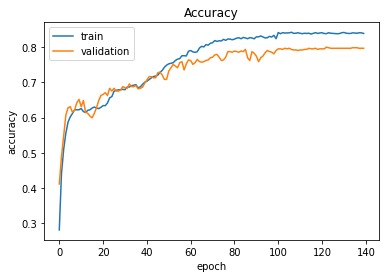

In [25]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()